In [1]:
import os

os.chdir("..")
%load_ext autoreload

%autoreload 2
from src.transforms.generate import (
    Preprocess,
    CreateSynthVolume,
    FinalCrop,
    get_matrices,
    get_motion_dist,
    get_affine,
)
from src.transforms.load import ToSoftLabel
import matplotlib.pyplot as plt
import torchio as tio
from torchio.transforms import RandomElasticDeformation
from torchvision.transforms import ToPILImage
from monai.transforms.intensity.array import ScaleIntensity
from monai.transforms import RandomizableTransform, CutMix
from torchio import Subject
import seaborn as sb
import numpy as np
import torch
import pandas as pd
from monai.transforms import (
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityd,
    CenterSpatialCropd,
    RandomizableTransform,
)
from torchio.transforms import (
    RandomElasticDeformation,
    RandomGamma,
    RandomFlip,
    RandomBiasField,
)
from monai.data.meta_tensor import MetaTensor
import torchvision.transforms.v2 as v2

(metatensor(1.), metatensor(0.))

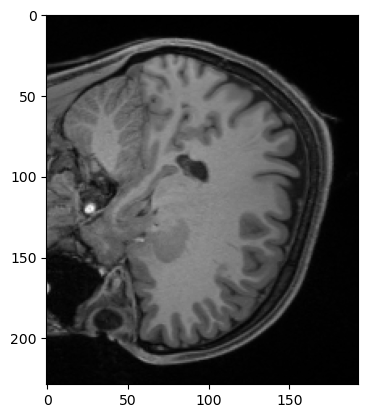

In [7]:
newp = Compose(
    [
        LoadImaged(keys="data", ensure_channel_first=True, image_only=True),
        Orientationd(keys="data", axcodes="RAS"),
        ScaleIntensityd(keys="data", minv=0, maxv=1),
    ]
)
unp = newp(
    {
        "data": r"C:\Users\Brico\Code\Master\mrart\data_test\ampscz\clear\sub-MT03607_ses-202212291_rec-norm_run-1_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz"
    }
)
plt.imshow(unp["data"][0, 120, :, :], cmap="gray")
unp["data"].max(), unp["data"].min()

(metatensor(0.9225), metatensor(0.), 1.049183658281163)

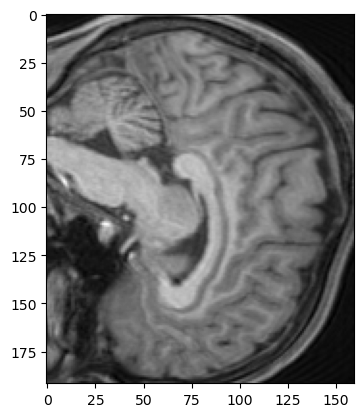

In [6]:
from src.config import BIN_RANGE, BIN_STEP
synth = Compose([Preprocess(), CreateSynthVolume(), FinalCrop(),])
rgunp = synth(
    {
        "data": r"C:\Users\Brico\Code\Master\mrart\data_test\ampscz\clear\sub-MT03607_ses-202212291_rec-norm_run-1_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz",
        "sub_id": "fdsf",
        "ses_id": "fsf",
    }
)
soft=ToSoftLabel(keys="label",backup_keys="motion_mm",bin_range=BIN_RANGE,
            bin_step=BIN_STEP,)
rgunp['label']=rgunp['motion_mm']
rgunp = soft(rgunp)
plt.imshow(rgunp["data"][0, 85, :, :], cmap="gray")
rgunp["data"].max(), rgunp["data"].min(), rgunp["motion_mm"]

In [8]:
batch  = torch.concat([rgunp["data"],rgunp["data"],rgunp["data"]])
batch = MetaTensor(batch)
batch_label =  torch.Tensor([rgunp["label"],rgunp["label"],rgunp["label"]])
batch_label

C:\Users\Brico\AppData\Local\Temp\ipykernel_43392\560354806.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  batch_label =  torch.Tensor([rgunp["label"],rgunp["label"],rgunp["label"]])


tensor([[3.2230e-44, 2.5597e-39, 1.0341e-34, 2.0955e-30, 2.1313e-26, 1.0888e-22,
         2.7965e-19, 3.6156e-16, 2.3564e-13, 7.7559e-11, 1.2921e-08, 1.0925e-06,
         4.7033e-05, 1.0349e-03, 1.1687e-02, 6.8018e-02, 2.0475e-01, 3.1968e-01,
         2.5916e-01, 1.0904e-01, 2.3755e-02, 2.6708e-03, 1.5435e-04, 4.5655e-06,
         6.8853e-08, 5.2760e-10, 2.0481e-12, 3.9968e-15, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.2230e-44, 2.5597e-39, 1.0341e-34, 2.0955e-30, 2.1313e-26, 1.0888e-22,
         2.7965e-19, 3.6156e-16, 2.3564e-13, 7.7559e-11, 1.2921e-08, 1.0925e-06,
         4.7033e-05, 1.0349e-03, 1.1687e-02, 6.8018e-02, 2.0475e-01, 3.1968e-01,
         2.5916e-01, 1.0904e-01, 2.3755e-02, 2.6708e-03, 1.5435e-04, 4.5655e-06,
         6.8853e-08, 5.2760e-10, 2.0481e-12, 3.9968e-15, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

In [9]:
cm =v2.CutMix(num_classes=None)
cm(batch, batch_label).shape

ValueError: labels tensor should be of shape (batch_size,) but got shape torch.Size([3, 40]) instead.

In [184]:
sub_unp = Subject(data=tio.ScalarImage(tensor=unp["data"]))
aug = tio.transforms.RandomMotion(degrees=0, translation=1, num_transforms=8)
vol = aug(sub_unp)
affine_matrice = get_matrices(vol.get_composed_history()[0])
motion_mm = get_motion_dist(affine_matrice)
motion_mm

1.5623103714678956

In [270]:
from collections import defaultdict
from typing import Dict


class CustomMotion(tio.transforms.RandomMotion, RandomizableTransform):
    def __init__(self, goal_motion):
        self.transform_degrees = self.R.uniform(0, np.min((goal_motion / 3, 1)))
        self.goal_motion = goal_motion
        self.num_transforms = self.R.randint(4, 8)

        super().__init__(
            self.transform_degrees,
            goal_motion,
            self.num_transforms,
            image_interpolation="bspline",
        )

    def apply_transform(self, subject: Subject) -> Subject:
        arguments: Dict[str, dict] = defaultdict(dict)
        for name, image in self.get_images_dict(subject).items():
            motion_mm = -1
            while (
                motion_mm > self.goal_motion + 0.01
                or motion_mm < self.goal_motion - 0.01
            ):
                params = self.get_params(
                    self.degrees_range,
                    self.translation_range,
                    self.num_transforms,
                    is_2d=image.is_2d(),
                )
                times_params, degrees_params, translation_params = params
                rotations = degrees_params
                translations = translation_params
                affine_matrices = [np.eye(4)]
                for rot, transl in zip(rotations, translations):
                    affine_matrices.append(get_affine(rot, transl))
                motion_mm = get_motion_dist(affine_matrices)
                print(f"Got {motion_mm}")

            arguments["times"][name] = times_params
            arguments["degrees"][name] = degrees_params
            arguments["translation"][name] = translation_params
            arguments["image_interpolation"][name] = self.image_interpolation
        transform = tio.transforms.Motion(**self.add_include_exclude(arguments))
        transformed = transform(subject)
        assert isinstance(transformed, Subject)
        return transformed

In [277]:
sub_unp = Subject(data=tio.ScalarImage(tensor=unp["data"]))
aug = CustomMotion(3.5)
vol = aug(sub_unp)
affine_matrice = get_matrices(vol.get_composed_history()[0])
motion_mm = get_motion_dist(affine_matrice)
motion_mm

Got 4.329288372573383
Got 4.798418636348384
Got 3.752497069385299
Got 3.816158419683824
Got 5.007214059188039
Got 3.9664376573144957
Got 4.8501952362973775
Got 5.185334560584644
Got 4.867583741625964
Got 4.010306939172992
Got 5.621849456828463
Got 5.77525600690065
Got 5.957993097937872
Got 5.716797710895274
Got 4.706318712840244
Got 5.224687043523679
Got 4.3736688944719395
Got 4.421264760284163
Got 4.622105904523378
Got 5.3104199176395825
Got 4.021357077128021
Got 4.898474834396358
Got 5.313767251726607
Got 4.7676675234635075
Got 4.092267207721
Got 4.209416050484832
Got 5.307883968538622
Got 4.718675505441845
Got 5.033775768000861
Got 5.3485092684522035
Got 4.984655380904466
Got 3.0654657800851832
Got 5.50182853629833
Got 3.87094049332932
Got 5.293980758968929
Got 4.89093052886566
Got 6.038147939647097
Got 4.372805572097165
Got 5.71888873222187
Got 5.179090938954503
Got 5.621564828891414
Got 3.9065818342682643
Got 4.483705931156946
Got 4.37394655560347
Got 4.270963944192879
Got 5.44934

3.49854169888332

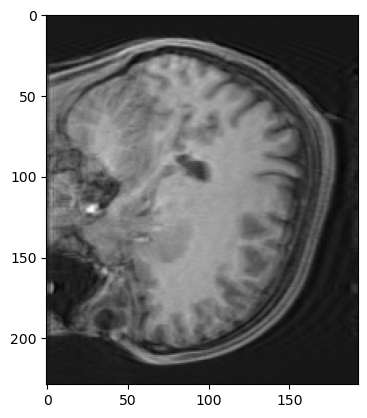

In [279]:
plt.imshow(vol.data.numpy()[0, 120, :, :], cmap="gray")

In [116]:
mot_transf = vol.get_composed_history()[0]
rot = mot_transf.degrees["data"][0]
transl = mot_transf.translation["data"][0]

rot, transl

(array([-1.4199283,  0.3282125,  1.3096974], dtype=float32),
 array([-4.274028  , -0.06572151, -0.8549614 ], dtype=float32))

In [99]:
from scipy.spatial.transform import Rotation
import numpy as np


def get_affine(rot, transl):
    rot_mat = Rotation.from_rotvec(rot, True).as_matrix()
    affine_matrix = np.eye(4)
    affine_matrix[:3, :3] = rot_mat
    affine_matrix[:3, 3] = transl
    return affine_matrix

In [100]:
affine_t2 = get_affine(rot, transl)
affine_t1 = np.eye(4)

In [101]:
from fsl.transform.affine import rmsdev

rmsdev(affine_t1, affine_t2)

4.237166783676317

In [27]:
from src.transforms.base_transform import get_affine, get_matrices, get_motion_dist

ImportError: cannot import name 'get_affine' from 'src.transforms.base_transform' (c:\Users\Brico\Code\Master\mrart\src\transforms\base_transform.py)

In [118]:
affines = get_matrices(mot_transf)
get_motion_dist(affines)

6.109195399933818

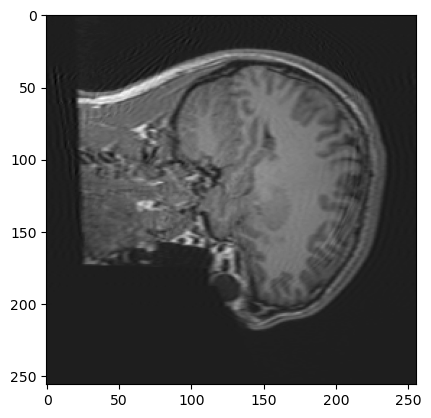

In [15]:
convert = ToPILImage(mode="L")
scale_01 = ScaleIntensity()
scaled = scale_01(vol)
converted = convert(scaled[0, 120, :, :])
plt.imshow(converted, cmap="gray")

(tensor(1209.9664),
 tensor(-118.2302),
 array([2.05305612e-09, 1.03263280e-08, 4.80970070e-08, 2.07452832e-07,
        8.28613354e-07, 3.06490997e-06, 1.04982922e-05, 3.33009449e-05,
        9.78212382e-05, 2.66103198e-04, 6.70361270e-04, 1.56390749e-03,
        3.37876402e-03, 6.76005994e-03, 1.25253604e-02, 2.14920533e-02,
        3.41518681e-02, 5.02574739e-02, 6.84915697e-02, 8.64419128e-02,
        1.01032893e-01, 1.09358524e-01, 1.09621075e-01, 1.01762330e-01,
        8.74845712e-02, 6.96509567e-02, 5.13539103e-02, 3.50647105e-02,
        2.21726028e-02, 1.29841051e-02, 7.04134175e-03, 3.53627383e-03,
        1.64468340e-03, 7.08375393e-04, 2.82545266e-04, 1.04364928e-04,
        3.56994528e-05, 1.13085610e-05, 3.31734170e-06, 9.01173327e-07,
        2.26704324e-07, 5.28132202e-08, 1.13934383e-08, 2.27611474e-09,
        4.21073953e-10, 7.21349647e-11, 1.14432908e-11, 1.68109970e-12,
        2.28705943e-13, 2.87547763e-14]),
 2.062340740153439,
 array([-0.9305, -0.7915, -0.6525,

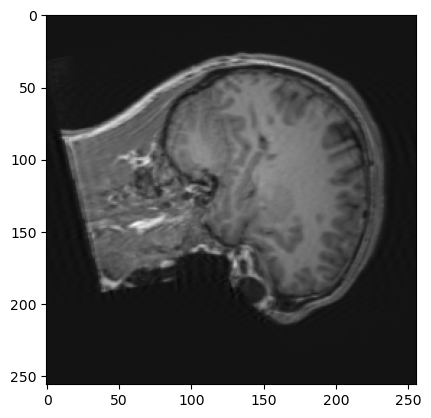

In [12]:
aug = CreateSynthVolume(elastic_activate=False)
vol = aug(unp)
plt.imshow(vol["data"][0, 120, :, :], cmap="gray")
vol["data"].max(), vol["data"].min(), vol["label"], vol["motion_mm"], vol["bin_centers"]

In [15]:
def test_elast(elast):
    res = elast(unp)
    auged = res["data"]
    unps = unp["data"]
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(unps[0, 120, :, :], cmap="gray")
    plt.title(f"Unprocessed Min:{unps.min()}, Max: {unps.max()}")
    plt.subplot(122)
    plt.imshow(auged[0, 120, :, :], cmap="gray")
    plt.title(f"Min:{auged.min()}, Max: {auged.max()}, mm: {res['motion_mm']}")

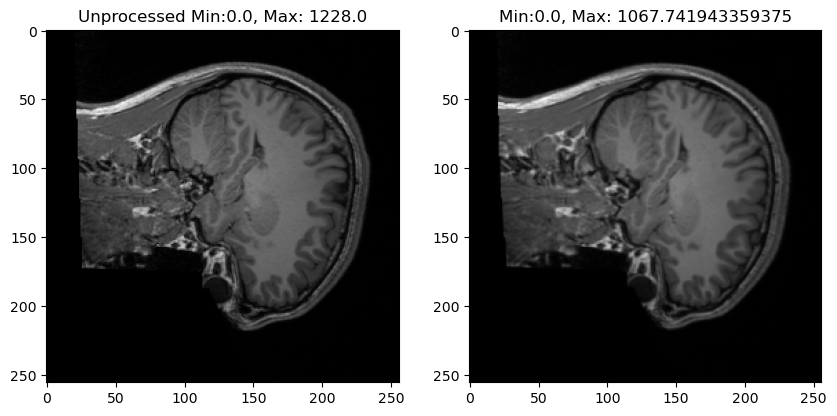

In [116]:
elast = RandomElasticDeformation(7, 9)
test_elast(elast)

In [2]:
train = pd.read_csv("src/dataset/pretraining/train.csv", index_col=0)
val = pd.read_csv("src/dataset/pretraining/val.csv", index_col=0)
train["motion_mm"].max(), val["motion_mm"].max()

(3.412450209991719, 3.3929615953447945)

c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


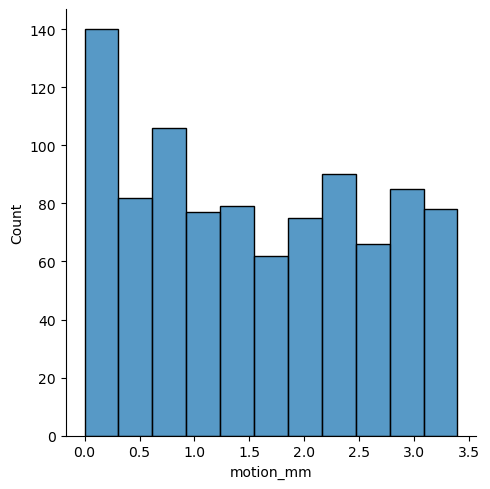

In [3]:
sb.displot(val, x="motion_mm")

c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


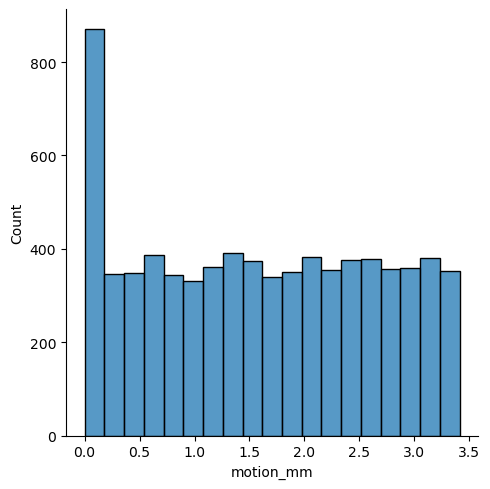

In [4]:
sb.displot(train, x="motion_mm")

c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='motion_mm', ylabel='Count'>

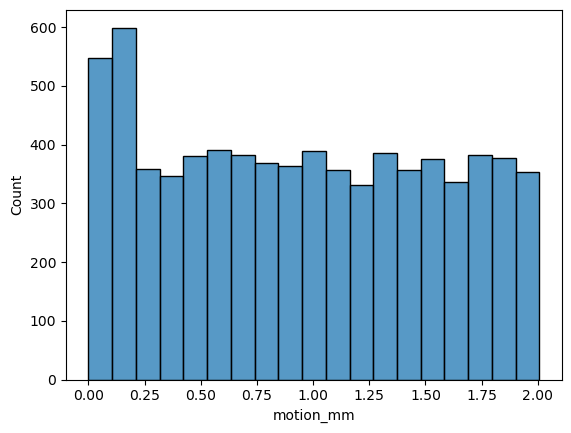

In [5]:
val_analysis = pd.read_csv(r"C:\Users\Brico\Downloads\train(6).csv")
sb.histplot(val_analysis, x="motion_mm")